# Image Classification with VGG and ResNet

This tutorial will introduce the attribution of image classifiers using VGG11
and ResNet18 trained on ImageNet. Feel free to replace VGG11 and ResNet18 with
any other version of VGG or ResNet respectively.

## Table of Contents
* [1. Preparation](<#1.-Preparation>)
* [2. VGG11 without BatchNorm](<#2.-VGG11-without-BatchNorm>)
    * [2.1 Saliency Map](<#2.1-Saliency-Map>)
    * [2.2 SmoothGrad using Attributors](<#2.2-SmoothGrad-using-Attributors>)
    * [2.3 Layer-wise Relevance Propagation (LRP) with EpsilonPlusFlat](<#2.3-Layer-wise-Relevance-Propagation-(LRP)-with-EpsilonPlusFlat>)
    * [2.4 LRP with EpsilonGammaBox](<#2.4-LRP-with-EpsilonGammaBox>)
    * [2.5 LRP with EpsilonGammaBox with modified epsilon and stabilizer](<#2.5-LRP-with-EpsilonGammaBox-with-modified-epsilon-and-stabilizer>)
    * [2.6 More Visualization](<#2.6-More-Visualization>)
* [3. VGG11 with BatchNorm](<#3.-VGG11-with-BatchNorm>)
    * [3.1 LRP with EpsilonGammaBox](<#3.1-LRP-with-EpsilonGammaBox>)
    * [3.2 LRP with modified EpsilonGammaBox and ignored BatchNorm](<#3.2-LRP-with-modified-EpsilonGammaBox-and-ignored-BatchNorm>)
    * [3.3 LRP with custom NameMapComposite](<#3.3-LRP-with-custom-NameMapComposite>)
* [4. ResNet18](<#4.-ResNet18>)
    * [4.1 LRP with EpsilonPlusFlat](<#4.1-LRP-with-EpsilonPlusFlat>)
    * [4.2 LRP with EpsilonGammaBox](<#4.2-LRP-with-EpsilonGammaBox>)
    * [4.3 LRP with custom LayerMapComposite](<#4.3-LRP-with-custom-LayerMapComposite>)

## 1. Preparation

First, we install **Zennit**. This includes its dependencies `Pillow`,
`torch` and `torchvision`:

In [1]:
%pip install zennit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 KB 1.2 MB/s eta 0:00:00


Then, we import necessary modules, classes and functions:

In [2]:
from itertools import islice

import torch
from torch.nn import Linear
from PIL import Image
from torchvision.transforms import Compose, Resize, CenterCrop
from torchvision.transforms import ToTensor, Normalize
from torchvision.models import vgg11_bn, vgg11, resnet18

from zennit.attribution import Gradient, SmoothGrad
from zennit.core import Stabilizer
from zennit.composites import EpsilonGammaBox, EpsilonPlusFlat
from zennit.composites import SpecialFirstLayerMapComposite, NameMapComposite
from zennit.image import imgify, imsave
from zennit.rules import Epsilon, ZPlus, ZBox, Norm, Pass, Flat
from zennit.types import Convolution, Activation, AvgPool, Linear as AnyLinear
from zennit.types import BatchNorm, MaxPool
from zennit.torchvision import VGGCanonizer, ResNetCanonizer

We download an image of the [Dornbusch
Lighthouse](https://en.wikipedia.org/wiki/Dornbusch_Lighthouse) from [Wikimedia
Commons](https://commons.wikimedia.org/wiki/File:2006_09_06_180_Leuchtturm.jpg):

In [3]:
torch.hub.download_url_to_file(
    'https://upload.wikimedia.org/wikipedia/commons/thumb/8/8b/2006_09_06_180_Leuchtturm.jpg/640px-2006_09_06_181_Leuchtturm.jpg',
    'dornbusch-lighthouse.jpg',
)

  0%|          | 0.00/45.6k [00:00<?, ?B/s]

We load and prepare the data. The image is resized such that the shorter side
is 256 pixels in size, then center-cropped to `(224, 224)`, converted to a
`torch.Tensor`, and then normalized according the channel-wise mean and
standard deviation of the ImageNet dataset:

In [4]:
# define the base image transform
transform_img = Compose([
    Resize(256),
    CenterCrop(224),
])
# define the normalization transform
transform_norm = Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
# define the full tensor transform
transform = Compose([
    transform_img,
    ToTensor(),
    transform_norm,
])

# load the image
image = Image.open('dornbusch-lighthouse.jpg')

# transform the PIL image and insert a batch-dimension
data = transform(image)[None]

We can look at the original image and the cropped image:

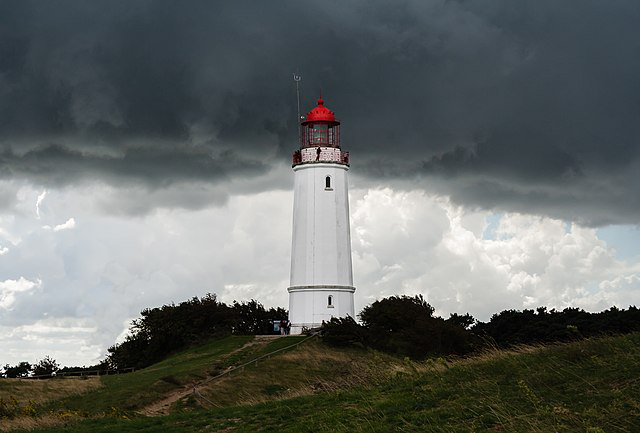

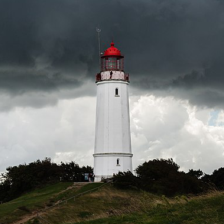

In [5]:
# display the original image
display(image)
# display the resized and cropped image
display(transform_img(image))

## 2. VGG11 without BatchNorm

We start with VGG11 without BatchNorm.
First, we initialize the VGG16 model and optionally load the hyperparameters.
Set `weights='IMAGENET1K_V1'` to use the pre-trained model instead of the random
one:

In [6]:
# load the model and set it to evaluation mode
model = vgg11(weights=None).eval()

### 2.1 Saliency Map
We first compute the Saliency Map, which is the absolute gradient, by using the
`Gradient` **Attributor**:

In [7]:
# choose a target class for the attribution (label 437 is lighthouse)
target = torch.eye(1000)[[437]]

# create the attributor, specifying model
with Gradient(model=model) as attributor:
    # compute the model output and attribution
    output, attribution = attributor(data, target)

print(f'Prediction: {output.argmax(1)[0].item()}')

Prediction: 364


Visualize the attribution:

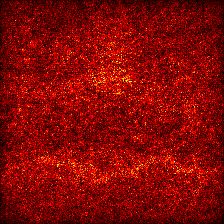

In [8]:
# absolute sum over the channels
relevance = attribution.abs().sum(1)

# create an image of the visualize attribution the relevance is only
# positive, so we use symmetric=False and an unsigned color-map
img = imgify(relevance, symmetric=False, cmap='hot')

# show the image
display(img)

### 2.2 SmoothGrad using Attributors
Model-agnostic attribution methods like *SmoothGrad* are implemented as
*Attributors*. For these, we simply replace the `Gradient` **Attributor**,
e.g., with  the `SmoothGrad` **Attributor**:

In [9]:
# choose a target class for the attribution (label 437 is lighthouse)
target = torch.eye(1000)[[437]]

# create the attributor, specifying model
with SmoothGrad(noise_level=0.1, n_iter=20, model=model) as attributor:
    # compute the model output and attribution
    output, attribution = attributor(data, target)

print(f'Prediction: {output.argmax(1)[0].item()}')

Prediction: 364


Visualize the attribution:

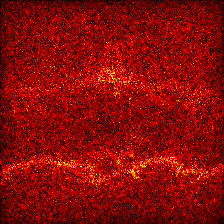

In [10]:
# take the absolute and sum over the channels
relevance = attribution.abs().sum(1)

# create an image of the visualize attribution the relevance is only
# positive, so we use symmetric=False and an unsigned color-map
img = imgify(relevance, symmetric=False, cmap='hot')

# show the image
display(img)

### 2.3 Layer-wise Relevance Propagation (LRP) with EpsilonPlusFlat
We compute the LRP-attribution using the *Gradient* **Attributor**
together with the `EpsilonPlusFlat` **Composite**:

In [11]:
# create a composite
composite = EpsilonPlusFlat()

# choose a target class for the attribution (label 437 is lighthouse)
target = torch.eye(1000)[[437]]

# create the attributor, specifying model and composite
with Gradient(model=model, composite=composite) as attributor:
    # compute the model output and attribution
    output, attribution = attributor(data, target)

print(f'Prediction: {output.argmax(1)[0].item()}')

Prediction: 364


Visualize the attribution:

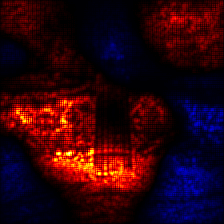

In [12]:
# sum over the channels
relevance = attribution.sum(1)

# create an image of the visualize attribution
img = imgify(relevance, symmetric=True, cmap='coldnhot')

# show the image
display(img)

### 2.4 LRP with EpsilonGammaBox
We now compute the LRP-attribution with the `EpsilonGammaBox` **Composite**.
The `EpsilonGammaBox` **Composite** uses the `ZBox` rule, which needs as
arguments the lowest and highest possible values.

In [13]:
# the EpsilonGammaBox composite needs the lowest and highest values, which are
# here for ImageNet 0. and 1. with a different normalization for each channel
low, high = transform_norm(torch.tensor([[[[[0.]]] * 3], [[[[1.]]] * 3]]))

# create a composite, specifying required arguments
composite = EpsilonGammaBox(low=low, high=high)

# choose a target class for the attribution (label 437 is lighthouse)
target = torch.eye(1000)[[437]]

# create the attributor, specifying model and composite
with Gradient(model=model, composite=composite) as attributor:
    # compute the model output and attribution
    output, attribution = attributor(data, target)

print(f'Prediction: {output.argmax(1)[0].item()}')

Prediction: 364


Visualize the attribution:

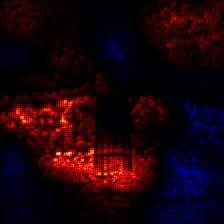

In [14]:
# sum over the channels
relevance = attribution.sum(1)

# create an image of the visualize attribution
img = imgify(relevance, symmetric=True, cmap='coldnhot')

# show the image
display(img)

### 2.5 LRP with EpsilonGammaBox with modified epsilon and stabilizer
We again compute the LRP-attribution with the `EpsilonGammaBox` **Composite**.
This time, we change the epsilon and stabilizer values, which both stabilize the
denominator in their respective rules:

In [15]:
# the EpsilonGammaBox composite needs the lowest and highest values, which are
# here for ImageNet 0. and 1. with a different normalization for each channel
low, high = transform_norm(torch.tensor([[[[[0.]]] * 3], [[[[1.]]] * 3]]))

# create a composite, specifying required arguments
composite = EpsilonGammaBox(
    low=low,
    high=high,
    epsilon=Stabilizer(epsilon=0.1, norm_scale=True),
    stabilizer=lambda x: ((x == 0.) + x.sign()) * x.abs().clip(min=1e-6),
)

# choose a target class for the attribution (label 437 is lighthouse)
target = torch.eye(1000)[[437]]

# create the attributor, specifying model and composite
with Gradient(model=model, composite=composite) as attributor:
    # compute the model output and attribution
    output, attribution = attributor(data, target)

print(f'Prediction: {output.argmax(1)[0].item()}')

Prediction: 364


Visualize the attribution:

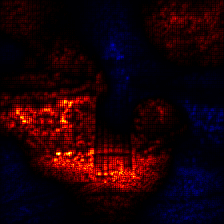

In [16]:
# sum over the channels
relevance = attribution.sum(1)

# create an image of the visualize attribution
img = imgify(relevance, symmetric=True, cmap='coldnhot')

# show the image
display(img)

### 2.6 More Visualization
We can try out different color-maps by either using another built-in color map, or using the color-map specification language:

Built-in color-map bwr


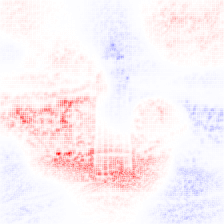

CMLS code for color-map from cyan to grey to purple


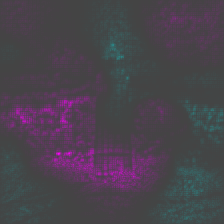

CMSL code for grey scale for negative and red for positive values


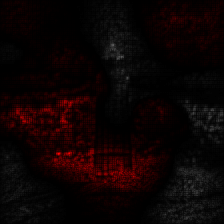

In [17]:
print('Built-in color-map bwr')
display(imgify(relevance, symmetric=True, cmap='bwr'))

print('CMLS code for color-map from cyan to grey to purple')
display(imgify(relevance, symmetric=True, cmap='0ff,444,f0f'))

print('CMSL code for grey scale for negative and red for positive values')
display(imgify(relevance, symmetric=True, cmap='fff,000,f00'))

To directly save the visualized attribution, we can use `imsave` instead:

In [18]:
# directly save the visualized attribution
imsave('attrib-1.png', relevance, symmetric=True, cmap='bwr')

## 3. VGG11 with BatchNorm

VGG11 with BatchNorm requires a canonizer for LRP to function properly. We
initialize the VGG11-bn model and optionally load the hyperparameters. Set
`weights='IMAGENET1K_V1'` to use the pre-trained model instead of the random
one:

In [ ]:
# load the model and set it to evaluation mode
model = vgg11_bn(weights=None).eval()

### 3.1 LRP with EpsilonGammaBox
We now compute the LRP-attribution with the `EpsilonGammaBox` **Composite**.

In [ ]:
# use the VGG-specific canonizer (alias for SequentialMergeBatchNorm, only
# needed with batch-norm)
canonizer = VGGCanonizer()

# the EpsilonGammaBox composite needs the lowest and highest values, which are
# here for ImageNet 0. and 1. with a different normalization for each channel
low, high = transform_norm(torch.tensor([[[[[0.]]] * 3], [[[[1.]]] * 3]]))

# create a composite, specifying arguments and the canonizers
composite = EpsilonGammaBox(low=low, high=high, canonizers=[canonizer])

# choose a target class for the attribution (label 437 is lighthouse)
target = torch.eye(1000)[[437]]

# create the attributor, specifying model and composite
with Gradient(model=model, composite=composite) as attributor:
    # compute the model output and attribution
    output, attribution = attributor(data, target)

print(f'Prediction: {output.argmax(1)[0].item()}')

Visualize the attribution:

In [ ]:
# sum over the channels
relevance = attribution.sum(1)

# create an image of the visualize attribution
img = imgify(relevance, symmetric=True, cmap='coldnhot')

# show the image
display(img)

### 3.2 LRP with modified EpsilonGammaBox and ignored BatchNorm
We can modify the EpsilonGammaBox by changing the epsilon/ gamma, and supplying
different layer mappings. Here, we explicitly ignore the BatchNorm layers,
instead of merging them in the adjacent linear layer by not supplying the
`VGGCanonizer`:

In [ ]:
# the EpsilonGammaBox composite needs the lowest and highest values, which are
# here for ImageNet 0. and 1. with a different normalization for each channel
low, high = transform_norm(torch.tensor([[[[[0.]]] * 3], [[[[1.]]] * 3]]))

# create a composite, specifying arguments and canonizers
composite = EpsilonGammaBox(
    low=low,
    high=high,
    canonizers=[],
    gamma=0.5, # change the gammma for all layers
    epsilon=0.1, # change the epsilon for all layers
    layer_map=[
        (BatchNorm, Pass()), # explicitly ignore BatchNorm
    ]
)

# choose a target class for the attribution (label 437 is lighthouse)
target = torch.eye(1000)[[437]]

# create the attributor, specifying model and composite
with Gradient(model=model, composite=composite) as attributor:
    # compute the model output and attribution
    output, attribution = attributor(data, target)

print(f'Prediction: {output.argmax(1)[0].item()}')

Visualize the attribution:

In [ ]:
# sum over the channels
relevance = attribution.sum(1)

# create an image of the visualize attribution
img = imgify(relevance, symmetric=True, cmap='coldnhot')

# show the image
display(img)

### 3.3 LRP with custom NameMapComposite
Here we demonstrate how rules can be assigned on a name-base using the abstract
`NameMapComposite`. Note that this particular case will only work with VGG11-bn,
so we redefine the model (set `weights='IMAGENET1K_V1'` to use the
pre-trained model):

In [ ]:
# load the model and set it to evaluation mode
model = vgg11_bn(weights=None).eval()

We can take a look at all leaf modules by doing the following:

In [ ]:
leaves = [
    (name, module)
    for name, module in model.named_modules()
    if not [*islice(module.children(), 1)]
]
maxlen = max(len(name) for name, _ in leaves)
print('\n'.join(f'{name:{maxlen}s}: {module}' for name, module in leaves))

We can look at the architecture and then assign the rules directly to the names:

In [ ]:
name_map = [
    (['features.0'], Flat()),  # Conv2d
    (['features.1'], Pass()),  # BatchNorm2d
    (['features.2'], Pass()),  # ReLU
    (['features.3'], Norm()),  # MaxPool2d
    (['features.4'], ZPlus()),  # Conv2d
    (['features.5'], Pass()),  # BatchNorm2d
    (['features.6'], Pass()),  # ReLU
    (['features.7'], Norm()),  # MaxPool2d
    (['features.8'], ZPlus()),  # Conv2d
    (['features.9'], Pass()),  # BatchNorm2d
    (['features.10'], Pass()),  # ReLU
    (['features.11'], ZPlus()),  # Conv2d
    (['features.12'], Pass()),  # BatchNorm2d
    (['features.13'], Pass()),  # ReLU
    (['features.14'], Norm()),  # MaxPool2d
    (['features.15'], ZPlus()),  # Conv2d
    (['features.16'], Pass()),  # BatchNorm2d
    (['features.17'], Pass()),  # ReLU
    (['features.18'], ZPlus()),  # Conv2d
    (['features.19'], Pass()),  # BatchNorm2d
    (['features.20'], Pass()),  # ReLU
    (['features.21'], Norm()),  # MaxPool2d
    (['features.22'], ZPlus()),  # Conv2d
    (['features.23'], Pass()),  # BatchNorm2d
    (['features.24'], Pass()),  # ReLU
    (['features.25'], ZPlus()),  # Conv2d
    (['features.26'], Pass()),  # BatchNorm2d
    (['features.27'], Pass()),  # ReLU
    (['features.28'], Norm()),  # MaxPool2d
    (['avgpool'], Norm()),  # AdaptiveAvgPool2d
    (['classifier.0'], Epsilon()),  # Linear
    (['classifier.1'], Pass()),  # ReLU
    (['classifier.2'], Pass()),  # Dropout
    (['classifier.3'], Epsilon()),  # Linear
    (['classifier.4'], Pass()),  # ReLU
    (['classifier.5'], Pass()),  # Dropout
    (['classifier.6'], Epsilon()),  # Linear
]

Now we can use the name-map to create the composite:

In [ ]:
# use the VGG-specific canonizer (alias for SequentialMergeBatchNorm, only
# needed with batch-norm)
canonizer = VGGCanonizer()

# create a composite, specifying arguments and canonizers
composite = NameMapComposite(
    name_map=name_map,
    canonizers=[canonizer],
)

# choose a target class for the attribution (label 437 is lighthouse)
target = torch.eye(1000)[[437]]

# create the attributor, specifying model and composite
with Gradient(model=model, composite=composite) as attributor:
    # compute the model output and attribution
    output, attribution = attributor(data, target)

print(f'Prediction: {output.argmax(1)[0].item()}')

Visualize the attribution:

In [ ]:
# sum over the channels
relevance = attribution.sum(1)

# create an image of the visualize attribution
img = imgify(relevance, symmetric=True, cmap='coldnhot')

# show the image
display(img)

## 4. ResNet18
We initialize the ResNet18 model and optionally load the hyperparameters. Set
`weights='IMAGENET1K_V1'` to use the pre-trained model instead of the random one:

In [ ]:
# load the model and set it to evaluation mode
model = resnet18(weights=None).eval()

### 4.1 LRP with EpsilonPlusFlat
Compute the LRP-attribution using the ``EpsilonPlusFlat`` **Composite**:

In [ ]:
# use the ResNet-specific canonizer
canonizer = ResNetCanonizer()

# create a composite, specifying the canonizers
composite = EpsilonPlusFlat(canonizers=[canonizer])

# choose a target class for the attribution (label 437 is lighthouse)
target = torch.eye(1000)[[437]]

# create the attributor, specifying model and composite
with Gradient(model=model, composite=composite) as attributor:
    # compute the model output and attribution
    output, attribution = attributor(data, target)

print(f'Prediction: {output.argmax(1)[0].item()}')

Visualize the attribution:

In [ ]:
# sum over the channels
relevance = attribution.sum(1)

# create an image of the visualize attribution
img = imgify(relevance, symmetric=True, cmap='coldnhot')

# show the image
display(img)

### 4.2 LRP with EpsilonGammaBox
Compute the LRP-attribution using the ``EpsilonGammaBox`` **Composite**:

In [ ]:
# use the ResNet-specific canonizer
canonizer = ResNetCanonizer()

# the ZBox rule needs the lowest and highest values, which are here for
# ImageNet 0. and 1. with a different normalization for each channel
low, high = transform_norm(torch.tensor([[[[[0.]]] * 3], [[[[1.]]] * 3]]))

# create a composite, specifying the canonizers, if any
composite = EpsilonGammaBox(low=low, high=high, canonizers=[canonizer])

# choose a target class for the attribution (label 437 is lighthouse)
target = torch.eye(1000)[[437]]

# create the attributor, specifying model and composite
with Gradient(model=model, composite=composite) as attributor:
    # compute the model output and attribution
    output, attribution = attributor(data, target)

print(f'Prediction: {output.argmax(1)[0].item()}')

Visualize the attribution:

In [ ]:
# sum over the channels
relevance = attribution.sum(1)

# create an image of the visualize attribution
img = imgify(relevance, symmetric=True, cmap='coldnhot')

# show the image
display(img)

### 4.3 LRP with custom LayerMapComposite
In this demonstration, we want to ignore the BatchNorm layers and attribute the
residual connections not by contribution but equally. This setup requires no **Canonizer**, but a special Composite which ignores the BatchNorm modules for LRP by assigning them the `Pass` rule.

In [ ]:
# the ZBox rule needs the lowest and highest values, which are here for
# ImageNet 0. and 1. with a different normalization for each channel
low, high = transform_norm(torch.tensor([[[[[0.]]] * 3], [[[[1.]]] * 3]]))

# create a composite, specifying the canonizers, if any
composite = SpecialFirstLayerMapComposite(
    # the layer map is a list of tuples, where the first element is the target
    # layer type, and the second is the rule template
    layer_map=[
        (Activation, Pass()),  # ignore activations
        (AvgPool, Norm()),  # normalize relevance for any AvgPool
        (Convolution, ZPlus()),  # any convolutional layer
        (Linear, Epsilon(epsilon=1e-6)),  # this is the dense Linear, not any
        (BatchNorm, Pass()),  # ignore BatchNorm
    ],
    # the first map is only used once, to the first module which applies to the
    # map, i.e. here the first layer of type AnyLinear
    first_map = [
        (AnyLinear, ZBox(low, high))
    ]
)

# choose a target class for the attribution (label 437 is lighthouse)
target = torch.eye(1000)[[437]]

# create the attributor, specifying model and composite
with Gradient(model=model, composite=composite) as attributor:
    # compute the model output and attribution
    output, attribution = attributor(data, target)

print(f'Prediction: {output.argmax(1)[0].item()}')

Visualize the attribution:

In [ ]:
# sum over the channels
relevance = attribution.sum(1)

# create an image of the visualize attribution
img = imgify(relevance, symmetric=True, cmap='coldnhot')

# show the image
display(img)